# Swing & Intraday Strategy( Using Renko & MACD)

Objective: This code is all about the swing and intraday strategy where we will buy and sell on the bases of three conditions.
We will be identifying signals and calculating daily return. This strategy works well for trending markets.

In [1]:
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 10)
pd.set_option('mode.chained_assignment', None)

In [3]:
# function to calculate MACD(Moving Avarage Convergence Divergence) typical values a = 12; b =26, c =9
def MACD(DF, a, b, c):
    df = DF.copy()
    df["MA_Fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    df["MA_Slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    df["MACD"] = df["MA_Fast"] - df["MA_Slow"]
    df["Signal"] = df["MACD"].ewm(span=c, min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"], df["Signal"])

In [4]:
# function to calculate True Range and Average True Range
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2

In [5]:
# function to calculate the slope of n consecutive points on a plot
def slope(ser, n):
    slopes = [i * 0 for i in range(n - 1)]
    for i in range(n, len(ser) + 1):
        y = ser[i - n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min()) / (y.max() - y.min())
        x_scaled = (x - x.min()) / (x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled, x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [24]:
# function to convert ohlc data into renko bricks
def renko_DF(DF):
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:, [0, 1, 2, 3, 4, 5]]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5, round(ATR(DF, 60)["ATR"][-1], 0))  
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"] == True, 1, np.where(renko_df["uptrend"] == False, -1, 0))
    for i in range(1, len(renko_df["bar_num"])):
        if renko_df["bar_num"][i] > 0 and renko_df["bar_num"][i - 1] > 0:
            renko_df["bar_num"][i] += renko_df["bar_num"][i - 1]
        elif renko_df["bar_num"][i] < 0 and renko_df["bar_num"][i - 1] < 0:
            renko_df["bar_num"][i] += renko_df["bar_num"][i - 1]
    renko_df.drop_duplicates(subset="date", keep="last", inplace=True)
    return renko_df

In [25]:
# Download historical data for DJI constituent stocks

tickers = ["MSFT", "AAPL", "FB", "AMZN"] 

ohlc_intraday = {}  # directory with ohlc value for each stock
key_path = "C:\\Users\\punit\\Desktop\\9010\\AplhaVantageKey.txt"
ts = TimeSeries(key=open(key_path, 'r').read(), output_format='pandas')

attempt = 0  # initializing passthrough variable
drop = []  # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i], interval='5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ["Open", "High", "Low", "Adj Close", "Volume"]
            drop.append(tickers[i])
        except:
            print(tickers[i], " :failed to fetch data...retrying")
            continue
    attempt += 1
    
tickers = ohlc_intraday.keys()  # redefine tickers variable after removing any tickers with corrupted data

In [26]:
# Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ", ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date", "open", "high", "low", "close", "uptrend", "bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:, ["Date", "bar_num"]], how="outer", on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill', inplace=True)
    ohlc_renko[ticker]["macd"] = MACD(ohlc_renko[ticker], 12, 26, 9)[0]
    ohlc_renko[ticker]["macd_sig"] = MACD(ohlc_renko[ticker], 12, 26, 9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"], 5)      # 5 sessions doesn't mean five days of data 
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"], 5) 
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []
ohlc_renko[ticker].dropna()

merging for  MSFT
merging for  AAPL
merging for  FB
merging for  AMZN


,Open,High,Low,Adj Close,Volume,Date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope
37,2940.450,2943.190,2936.0100,2937.7421,69900.0,2020-09-18 15:15:00,2.0,-3.103372,-1.839452,-44.041515,-44.925612
38,2933.840,2942.970,2931.9901,2940.2700,69605.0,2020-09-18 15:10:00,2.0,-3.105805,-2.104374,-46.304122,-45.109656
39,2933.920,2935.880,2928.6600,2933.1350,47757.0,2020-09-18 15:05:00,-1.0,-3.617107,-2.417954,-42.486197,-44.696258
40,2931.620,2936.000,2927.5101,2935.1083,50132.0,2020-09-18 15:00:00,-1.0,-3.824626,-2.707436,-45.065739,-44.760394
41,2936.545,2937.735,2928.1150,2931.0600,63293.0,2020-09-18 14:55:00,-1.0,-4.254414,-3.023959,-46.391691,-45.104375
...,...,...,...,...,...,...,...,...,...,...,...
2646,3298.300,3298.300,3298.3000,3298.3000,829.0,2020-08-21 07:10:00,1.0,0.873898,-0.285680,46.304662,42.878543
2647,3295.870,3300.000,3295.8700,3300.0000,1812.0,2020-08-21 07:05:00,1.0,1.401097,0.051675,45.331617,45.611691
2648,3302.000,3302.000,3302.0000,3302.0000,230.0,2020-08-21 05:45:00,1.0,1.957722,0.432885,44.163771,45.054363
2649,3301.000,3301.000,3301.0000,3301.0000,414.0,2020-08-21 04:20:00,1.0,2.291742,0.804656,45.695711,45.235226


In [27]:
# Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ", ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i] >= 2 and ohlc_renko[ticker]["macd"][i] > \
                        ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i] > \
                        ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"][i] <= -2 and ohlc_renko[ticker]["macd"][i] < \
                        ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i] < \
                        ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"

        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append(
                (ohlc_renko[ticker]["Adj Close"][i] / ohlc_renko[ticker]["Adj Close"][i - 1]) - 1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i] <= -2 and ohlc_renko[ticker]["macd"][i] < \
                        ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i] < \
                        ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
                elif ohlc_renko[ticker]["macd"][i] < ohlc_renko[ticker]["macd_sig"][i] and \
                        ohlc_renko[ticker]["macd_slope"][i] < ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""

        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append(
                (ohlc_renko[ticker]["Adj Close"][i - 1] / ohlc_renko[ticker]["Adj Close"][i]) - 1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i] >= 2 and ohlc_renko[ticker]["macd"][i] > \
                        ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i] > \
                        ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"][i] > ohlc_renko[ticker]["macd_sig"][i] and \
                        ohlc_renko[ticker]["macd_slope"][i] > ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])  # converting dict into dataframe


calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  FB
calculating daily returns for  AMZN


In [28]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

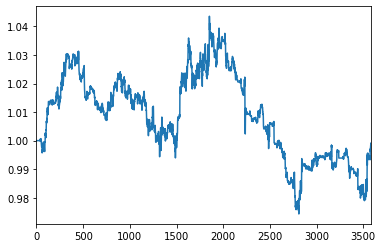

In [29]:
# visualizing strategy returns
(1 + strategy_df["ret"]).cumprod().plot()